In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log10

# from project_modules.utils import get_logger
# logger = get_logger("log-data-umap.log")
# read the parameter file

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

In [2]:
# make blobs using sklearn
from sklearn.datasets import make_blobs, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SAMPLES = 1_000
FEATURES = 25

# make blobs
X, y = make_classification(n_samples=SAMPLES, 
                            n_features=FEATURES, 
                            n_informative = 5,
                            random_state=42,
                            n_classes=3,
                            class_sep=2.5,
                            # flip_y=0.25,
                            )


# scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)



# make a 2d plot of the blobs

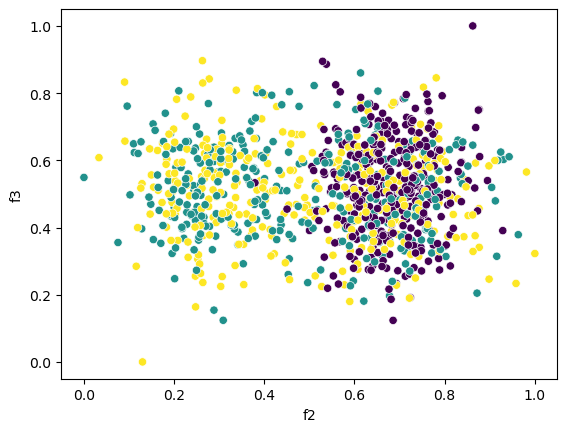

In [3]:
# plot the first two features on a sns scatter plot
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(FEATURES)])
# df["label"] = y
# df["label"] = df["label"].astype("category")

# plot the first two features
sns.scatterplot(data=df, x="f2", y="f3", c = y)
plt.show()

In [4]:
# split the synetetic data into a train set, test set, and holdout set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# fit a umap model to the training data
import umap
umap_model = umap.UMAP(
                        # n_neighbors=50, 
                        n_components=2, 
                        # metric = "euclidean",
                        # min_dist=0.1
                         )
umap_model.fit(X_train)


from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42)
tsne_model.fit(X_train)



# transform the training data
X_train_umap = umap_model.transform(X_train)
X_train_tsne = tsne_model.fit_transform(X_train)

# use hdbscan clustering to label the training data
import hdbscan
clusterer = hdbscan.HDBSCAN(
                                min_cluster_size=15, 
                                min_samples=5, 
                                prediction_data=True, 
                                cluster_selection_method="leaf"
                            )

# clusterer.fit(X_train_umap)
clusterer.fit(X_train_tsne)

df_train = pd.DataFrame(X_train_tsne, columns=["dim1", "dim2"])
# df_train = pd.DataFrame(X_train_umap, columns=["dim1", "dim2"])
df_train["true_label"] = y_train
df_train["cluster"] = clusterer.labels_


<Axes: xlabel='dim1', ylabel='dim2'>

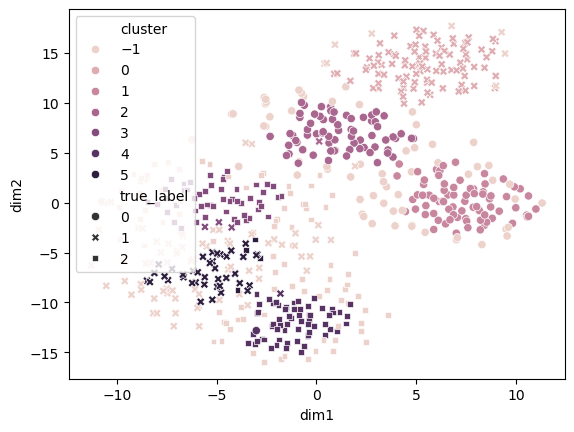

In [6]:
sns.scatterplot(data=df_train, x="dim1", y="dim2", hue="cluster", style = "true_label")

In [7]:

# apply the same umap_mdel to the test data and predict cluster membership
X_test_umap = umap_model.transform(X_test)
y_test_pred = hdbscan.approximate_predict(clusterer, X_test_umap)
y_test_pred = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_test_umap), axis = 1)
test_n = len(np.unique(y_holdout))

# apply the same umap_mdel to the holdout data and predict cluster membership
X_holdout_umap = umap_model.transform(X_holdout)
y_holdout_pred = hdbscan.approximate_predict(clusterer, X_holdout_umap)

holdout_n = len(np.unique(y_holdout))

# assign the most likely cluster
y_holdout_pred = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_holdout_umap), axis = 1)


df_test = pd.DataFrame(X_test_umap, columns=["dim1", "dim2"])
df_test["label"] = y_test_pred[0]

df_holdout = pd.DataFrame(X_holdout_umap, columns=["umap1", "dim2"])
df_holdout["label"] = y_holdout_pred[0]



In [8]:
print(f"Test: {test_n} clusters")
# sns.scatterplot(data=df_test, x="umap1", y="dim2", hue="label")

print(f"Holdout: {holdout_n} clusters")
# sns.scatterplot(data=df_holdout, x="umap1", y="dim2", hue="label")

Test: 3 clusters
Holdout: 3 clusters


In [9]:
# plot the first two features on a sns scatter plot
df = pd.DataFrame(X_train_umap, columns=[f"f{i}" for i in range(umap_model.n_components)])
df["label"] = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_train_umap), axis = 1)
df["label"] = df["label"].astype("category")

train_n = len(np.unique(y_train))

In [10]:
# palette - map the cluster labels to a color
import colorcet as cc

palette = cc.glasbey_hv

colours = {i: palette[i] for i in range(len(cc.glasbey_hv))}
colours

colours[-1] = "gray"

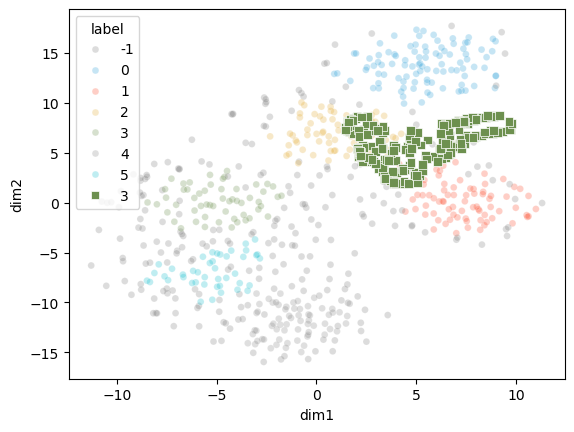

In [11]:

# plot the first two features
sns.scatterplot(data=df_train, x="dim1", y="dim2", hue="cluster", s=24, alpha=0.275, palette = colours)
sns.scatterplot(data = df_test, x="dim1", y="dim2", marker="s", s=40, hue = "label", palette = colours)
# sns.scatterplot(data = df_holdout, x="umap1", y="dim2", hue="label", marker="^", s=10, palette=  "tab10")


plt.show()

In [12]:
# modelling

In [13]:
# build an RFC model on the train set

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# evaluate the model on the test set
from sklearn.metrics import accuracy_score
y_test_pred = rfc.predict(X_test)
print(f"Evaluation on test set: {accuracy_score(y_test, y_test_pred)}")

# evaluate the model on the holdout set
y_holdout_pred = rfc.predict(X_holdout)
print(f"Evaluation on holdout set: {accuracy_score(y_holdout, y_holdout_pred)}")


Evaluation on test set: 0.99
Evaluation on holdout set: 0.98125


In [14]:
df

,f0,f1,label
0,4.234492,3.998591,2
1,2.797122,7.226419,2
2,9.131051,8.096997,0
3,2.846477,4.342505,2
4,9.382232,7.721120,0
...,...,...,...
635,6.445794,5.247151,2
636,8.655318,8.412316,0
637,9.470297,8.147321,0
638,6.052976,5.915897,2


In [15]:
X.shape

(1000, 25)

In [16]:
# hdbscan

clusterer = hdbscan.HDBSCAN(
                                min_cluster_size=100, 
                                min_samples=5, 
                                prediction_data=True, 
                                cluster_selection_method="eom"
                            )       

clusters = clusterer.fit_predict(X)
clusters 


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

<Axes: xlabel='umap1', ylabel='umap2'>

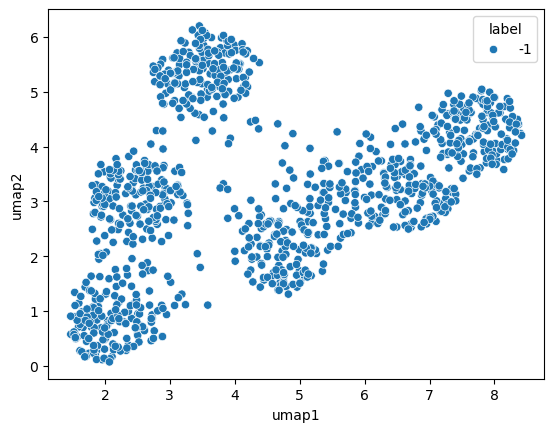

In [17]:
# reduce dimensions
umap_model = umap.UMAP(
                        n_neighbors=50, 
                        n_components=2, 
                        metric = "euclidean",
                        min_dist=0.1
                         )
umap_model.fit(X)

X_umap = umap_model.transform(X)
# X_umap = umap_model.transform(X, clusters.all())

df_umap = pd.DataFrame(X_umap, columns=["umap1", "umap2"])
df_umap["label"] = clusters

sns.scatterplot(data=df_umap, x="umap1", y="umap2", hue="label", palette="tab10")